# Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence, pad_sequence

import os
import sys
import time
import pickle
import logging
import random
import math
from math import log, ceil
from pathlib import Path
from typing import List, Tuple, Set, Dict

import numpy as np
import pandas as pd
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

from src.data import prepare_data, prepare_heatmap_data, SOURCE_ASSIST0910_SELF, SOURCE_ASSIST0910_ORIG
from src.utils import sAsMinutes, timeSince

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

# =========================
# PyTorch version & GPU setup
# =========================
print('PyTorch:', torch.__version__)
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', dev)

PyTorch: 1.0.1.post2
Using Device: cuda


In [2]:
# =========================
# Seed
# =========================
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# =========================
# Parameters
# =========================
# model_name = 'encdec'
sequence_size = 20
epoch_size = 1000
lr = 0.02
batch_size, n_hidden, n_skills, n_layers = 100, 200, 124, 1
n_output = n_skills
PRESERVED_TOKENS = 2  # PAD, SOS
onehot_size = 2 * n_skills + PRESERVED_TOKENS
n_input = ceil(log(2 * n_skills))
# n_input = onehot_size  #

NUM_EMBEDDIGNS, ENC_EMB_DIM, ENC_DROPOUT = onehot_size, n_input, 0.6
OUTPUT_DIM, DEC_EMB_DIM, DEC_DROPOUT = onehot_size, n_input, 0.6
# OUTPUT_DIM = n_output = 124  # TODO: ほんとはこれやりたい
HID_DIM, N_LAYERS = n_hidden, n_layers

# =========================
# Extensions
# =========================
extend_forward = 0

# =========================
# Data
# =========================
train_dl, eval_dl = prepare_data(
    SOURCE_ASSIST0910_ORIG, 'encdec', n_skills, PRESERVED_TOKENS, 
    min_n=3, max_n=sequence_size, batch_size=batch_size, device=dev, sliding_window=0,
    params={'extend_backward':0, 'extend_forward':extend_forward}
)

print(train_dl.dataset.tensors[2].size(), eval_dl.dataset.tensors[2].size())

# 違いを調整する <- ???
#OUTPUT_DIM = eval_dl.dataset.tensors[1].shape

torch.Size([13858, 1]) torch.Size([3251, 1])


## Model

In [3]:
# =========================
# Model
# =========================
class Encoder(nn.Module):
    def __init__(self, num_embeddings, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        # Layers
        self.embedding = nn.Embedding(num_embeddings, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell
    
    
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        # Layers
        self.embedding = nn.Embedding(output_dim, emb_dim)  # 250->6
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)  # 6, 100, 1
        
        self.out = nn.Linear(hid_dim, output_dim)  # 100, 250
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
#         print(input.shape)  # 1, 100
#         input = input.unsqueeze(0)
#         もしx_trg1つだけ取り出して渡すと上のようになるので、unsqueezeする。
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
#         prediction = self.out(output.squeeze(0))
        prediction = self.out(output)
        return prediction, hidden, cell

    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, dev):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = dev
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        max_len = trg.shape[0]  # should be 1
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        hidden, cell = self.encoder(src)
        
#         print(trg.shape) # 2, 100
#         input_trg = trg[-1,:]  # should be 1, 100, ?
        input_trg = trg
         
        output, hidden, cell = self.decoder(input_trg, hidden, cell)
#         print(output.shape) # 1, 100, 250
#         outputs = output.unsqueeze(0)
        outputs = output
        # Knowledge State
        o_wro = torch.sigmoid(output[:,:, 2:2+124])
        o_cor = torch.sigmoid(output[:,:, 2+124:])
#         print(o_wro.shape, o_cor.shape)  # 1, 100, 124; 1, 100, 124
#         outputs_prob = (o_cor / (o_cor + o_wro)).unsqueeze(0)
        outputs_prob = (o_cor / (o_cor + o_wro))
        
        return outputs, outputs_prob
    
    
def loss_batch_encdec(model, loss_func, *args, opt=None):
    # Unpack data from DataLoader
    xs_src, xs_trg, ys, yq, ya, yp = args
    input_src = xs_src
    input_trg = xs_trg
    target = ys
    input_src = input_src.permute(1, 0)
    input_trg = input_trg.permute(1, 0)
    target = target.permute(1, 0)

    out, out_prob = model(input_src, input_trg)
#     print(out.shape, out_prob.shape) # 1, 100, 250; 1, 100, 124
    out = out.permute(1, 0, 2)
    out_prob = out_prob.permute(1, 0, 2)

    pred = torch.sigmoid(out)  # [0, 1]区間にする

    # --- 指標評価用データ
#     print(yq.shape) # 100, 2, 124
#     prob = torch.max(out_prob * yq[:,-1,:].unsqueeze(1), 2)[0]
#     print(out_prob.shape, yq.shape)  # 100, 1, 124; 100, 1, 124
#     良いのでは？
    prob = torch.max(out_prob * yq, 2)[0]
    predicted = prob[:,-1 - extend_forward]
    actual = ya[:,-1 - extend_forward]
#     predicted = prob[:,-1]
#     actual = ya[:,-1]
    # ---
    
    # Knowledge State
#     predicted_ks = out_prob
    predicted_ks = out_prob[:,-1,:].unsqueeze(1)
    
    #print(predicted_ks.shape, yp.shape)

#     loss = loss_func(prob[:,-1], ya[:,-1]) 
    loss = loss_func(prob, ya) 

    if opt:
        # バックプロバゲーション
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    # Returns loss number, batch size
    return loss.item(), len(ys), predicted, actual, predicted_ks


loss_batch = loss_batch_encdec

In [4]:
# =========================
# Prepare and Train
# =========================
enc = Encoder(NUM_EMBEDDIGNS, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, dev).to(dev)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')


loss_func = nn.BCELoss()
opt = optim.SGD(model.parameters(), lr=lr)

/home/qqhann/miniconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/qqhann/miniconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


The model has 386,050 trainable parameters


## Main

start traing


Level 25:dkt log:TRAIN Epoch: 100 Loss: 0.5264443449568057
Level 25:dkt log:EVAL  Epoch: 100 Loss: 0.5332749541848898
Level 25:dkt log:EVAL  Epoch: 100 AUC: 0.7429363063627668
Level 25:dkt log:EVAL  Epoch: 100 AUC: 0.7429363063627668
Level 25:dkt log:1m 40s ( - 15m 1s) (100 10.0)
Level 25:dkt log:TRAIN Epoch: 200 Loss: 0.4786029651329137
Level 25:dkt log:EVAL  Epoch: 200 Loss: 0.49043164821341634
Level 25:dkt log:EVAL  Epoch: 200 AUC: 0.79142395355741
Level 25:dkt log:EVAL  Epoch: 200 AUC: 0.79142395355741
Level 25:dkt log:3m 14s ( - 12m 56s) (200 20.0)
Level 25:dkt log:TRAIN Epoch: 300 Loss: 0.4663697889317637
Level 25:dkt log:EVAL  Epoch: 300 Loss: 0.47869332134723663
Level 25:dkt log:EVAL  Epoch: 300 AUC: 0.8045083616452815
Level 25:dkt log:EVAL  Epoch: 300 AUC: 0.8045083616452815
Level 25:dkt log:4m 51s ( - 11m 20s) (300 30.0)
Level 25:dkt log:TRAIN Epoch: 400 Loss: 0.4594252840008425
Level 25:dkt log:EVAL  Epoch: 400 Loss: 0.4725240492261946
Level 25:dkt log:EVAL  Epoch: 400 AUC: 

100 100 100


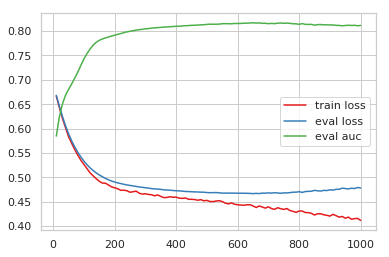

In [5]:
def main():
    debug = False
    logging.basicConfig()
    logger = logging.getLogger('dkt log')
    logger.setLevel(logging.INFO + 1)
    
    train_loss_list = []
    train_auc_list = []
    eval_loss_list = []
    eval_auc_list = []
    eval_recall_list = []
    eval_f1_list = []
    x = []
    
    start_time = time.time()
    for epoch in range(1, epoch_size + 1):
        print_train = epoch % 10 == 0
        print_eval = epoch % 10 == 0
        print_auc = epoch % 10 == 0

        
        # =====
        # TRAIN
        # =====
        model.train()

        # ------------------ train -----------------
        val_pred = []
        val_actual = []
        current_epoch_train_loss = []
        for args in train_dl:
            loss_item, batch_n, pred, actu, pred_ks = loss_batch(model, loss_func, *args, opt=opt)
            current_epoch_train_loss.append(loss_item)
            val_pred.append(pred)
            val_actual.append(actu)
            
            # stop at first batch if debug
            if debug:
                break
                
        if print_train:
            loss = np.array(current_epoch_train_loss)
            logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0),
                       'TRAIN Epoch: {} Loss: {}'.format(epoch, loss.mean()))
            train_loss_list.append(loss.mean())
            
            # # AUC, Recall, F1
            # # TRAINの場合、勾配があるから処理が必要
            # y = torch.cat(val_targ).cpu().detach().numpy()
            # pred = torch.cat(val_prob).cpu().detach().numpy()
            # # AUC
            # fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
            # logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
            #            'TRAIN Epoch: {} AUC: {}'.format(epoch, metrics.auc(fpr, tpr)))
            # train_auc_list.append(metrics.auc(fpr, tpr))
        # -----------------------------------


        # =====
        # EVAL
        # =====
        if print_eval:
            with torch.no_grad():
                model.eval()

                # ------------------ eval -----------------
                val_pred = []
                val_actual = []
                current_eval_loss = []
                for args in eval_dl:
                    loss_item, batch_n, pred, actu, pred_ks = loss_batch(model, loss_func, *args, opt=None)
                    current_eval_loss.append(loss_item)
                    val_pred.append(pred)
                    val_actual.append(actu)
                    
                    # stop at first batch if debug
                    if debug:
                        break
                        
                loss = np.array(current_eval_loss)
                logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
                           'EVAL  Epoch: {} Loss: {}'.format(epoch,  loss.mean()))
                eval_loss_list.append(loss.mean())

                # AUC, Recall, F1
                if print_auc:
                    y = torch.cat(val_actual).view(-1).cpu()  # TODO: viewしない？　最後の1個で？
                    pred = torch.cat(val_pred).view(-1).cpu()
                    # AUC
                    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
                    logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
                               'EVAL  Epoch: {} AUC: {}'.format(epoch, metrics.auc(fpr, tpr)))
                    logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0), 
                               'EVAL  Epoch: {} AUC: {}'.format(epoch, metrics.auc(fpr, tpr)))
                    eval_auc_list.append(metrics.auc(fpr, tpr))
                #     # Recall
                #     logger.debug('EVAL  Epoch: {} Recall: {}'.format(epoch, metrics.recall_score(y, pred.round())))
                #     # F1 score
                #     logger.debug('EVAL  Epoch: {} F1 score: {}'.format(epoch, metrics.f1_score(y, pred.round())))
                # -----------------------------------
        
        if epoch % 10 == 0:
            x.append(epoch)
            logger.log(logging.INFO + (5 if epoch % 100 == 0 else 0),
                       f'{timeSince(start_time, epoch / epoch_size)} ({epoch} {epoch / epoch_size * 100})')

        
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, train_loss_list, label='train loss')
    # ax.plot(x, train_auc_list, label='train auc')
    ax.plot(x, eval_loss_list, label='eval loss')
    ax.plot(x, eval_auc_list, label='eval auc')
    ax.legend()
    print(len(train_loss_list), len(eval_loss_list), len(eval_auc_list))
    plt.show()

    


if __name__ == '__main__':
    print('start traing')
    main()

In [6]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(250, 6)
    (rnn): LSTM(6, 200, dropout=0.6)
    (dropout): Dropout(p=0.6)
  )
  (decoder): Decoder(
    (embedding): Embedding(250, 6)
    (rnn): LSTM(6, 200, dropout=0.6)
    (out): Linear(in_features=200, out_features=250, bias=True)
    (dropout): Dropout(p=0.6)
  )
)

In [7]:
# import datetime
# now = datetime.datetime.now().strftime('%Y_%m%d_%H%M')

# torch.save(model.state_dict(), '/home/qqhann/encoder-decoder-dkt/models/eddkt_vanilla_' + now + '.' + str(800))

## Heatmap

In [8]:
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from src.data import (load_source, QandAEmbedder, slice_d, slide_d, split_encdec,
                      prepare_data, prepare_seq2seq_data, 
                      SOURCE_ASSIST0910_SELF, SOURCE_ASSIST0910_ORIG)

def prepare_heatmap_data(source, n_skills, preserved_tokens, min_n, max_n, batch_size, device, sliding_window:int=1): #TODO: fix sw
    data = load_source(source)

    M = n_skills
    sequence_size = max_n
    N = ceil(log(2 * M))
    
    qa_emb = QandAEmbedder(M, sequence_size)

    train_num = int(len(data) * .8)
    
    
    x_src_indexed = []
    x_trg_indexed = []
    y_indexed = []
    y_delta_q = []
    y_a = []
    y_prob_qa = []
    # TODO: 雑実装。一人のユーザに対してだけ取り出す
    for d in data:
        if len(d) < 80:
            continue
        for xsty_seq in slide_d(d, x_seq_size=sequence_size, type='encdec'):
            # Because it is not generative...
            # y is the last one
            x_src, x_trg, y = split_encdec(xsty_seq)
            x_src_indexed.append([qa_emb.qaToIdxNum(qa) for qa in x_src])
            x_trg_indexed.append([qa_emb.qaToIdxNum(qa) for qa in x_trg])
            y_indexed.append([qa_emb.qaToIdxNum(qa) for qa in y]) # コメント時効？→embedding済みは学習対象にしても仕方がない（か？）
            y_delta_q.append([qa_emb.qaToDeltaQ(qa) for qa in y])
            y_a.append([qa[1] for qa in y])
            # yで必要なのは確率分布124と、delta q, aのパターン
            # delta qから確率分布124を作成する
            y_prob_qa.append(qa_emb.sequenceToProbSeq(y))

        break


    all_ds = TensorDataset(
        torch.LongTensor(x_src_indexed).to(device), 
        torch.LongTensor(x_trg_indexed).to(device), 
        torch.LongTensor(y_indexed).to(device), 
        torch.Tensor(y_delta_q).to(device), 
        torch.Tensor(y_a).to(device), 
        torch.tensor(y_prob_qa).to(device),
    )
    
    

    all_dl = DataLoader(all_ds, batch_size=batch_size, drop_last=True)
    return all_dl

heat_dl = prepare_heatmap_data(
    SOURCE_ASSIST0910_ORIG, n_skills, PRESERVED_TOKENS, min_n=3, max_n=sequence_size, batch_size=batch_size, device=dev, sliding_window=0)

In [9]:
# heat_dl = prepare_heatmap_data(
#     SOURCE_ASSIST0910_ORIG, 'encdec', n_skills, PRESERVED_TOKENS, 
#     min_n=3, max_n=sequence_size, batch_size=batch_size, device=dev, sliding_window=0)


In [10]:
# Load model
# ----------
load_model = None

# load_model = '/home/qqhann/encoder-decoder-dkt/models/s2s_2019_0404_2021.100'
if load_model:
    enc = Encoder(NUM_EMBEDDIGNS, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(dev)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).to(dev)

    model = Seq2Seq(enc, dec, dev).to(dev)

    model.load_state_dict(torch.load(load_model))
    model = model.to(dev)
# ----------

In [11]:
def heatmap():
    debug = False 
    logging.basicConfig()
    logger = logging.getLogger('dkt log')
    logger.setLevel(logging.INFO)
    train_loss_list = []
    train_auc_list = []
    eval_loss_list = []
    eval_auc_list = []
    eval_recall_list = []
    eval_f1_list = []
    x = []
    
    with torch.no_grad():
        model.eval()
        # =====
        # HEATMAP
        # =====
        all_out_prob = []
        # ------------------ eval -----------------
        val_pred = []
        val_actual = []
        current_eval_loss = []
        for args in heat_dl:
            loss_item, batch_n, pred, actu, pred_ks = loss_batch(model, loss_func, *args, opt=None)
            current_eval_loss.append(loss_item)
            val_pred.append(pred)
            val_actual.append(actu)

#             print(pred_ks.shape)
            
            all_out_prob.append(pred_ks)
            
#             # stop at first batch if debug
#             if debug:
#                 break

        loss = np.array(current_eval_loss)
        logger.log(logging.INFO , 
                   'EVAL Loss: {}'.format( loss.mean()))
        eval_loss_list.append(loss.mean())

        # -----------------------------------
        
        # AUC, Recall, F1
        y = torch.cat(val_actual).view(-1).cpu()  # TODO: viewしない？　最後の1個で？
        pred = torch.cat(val_pred).view(-1).cpu()
        # AUC
        fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
        eval_auc_list.append(metrics.auc(fpr, tpr))
    #     # Recall
    #     logger.debug('EVAL  Epoch: {} Recall: {}'.format(epoch, metrics.recall_score(y, pred.round())))
    #     # F1 score
    #     logger.debug('EVAL  Epoch: {} F1 score: {}'.format(epoch, metrics.f1_score(y, pred.round())))
    
    print(eval_auc_list)
    return all_out_prob


if __name__ == '__main__':
    all_out_prob = heatmap()
    print('finish')

INFO:dkt log:EVAL Loss: 0.5510146021842957


[0.5925]
finish


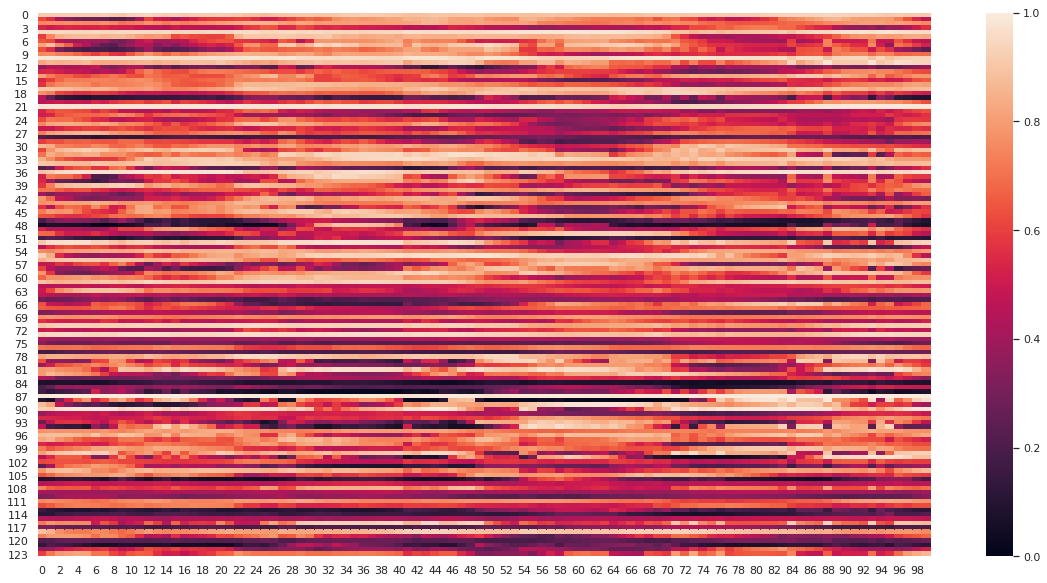

In [12]:
_d = all_out_prob[0].squeeze(1).t().cpu()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(_d, vmin=0, vmax=1, ax=ax)

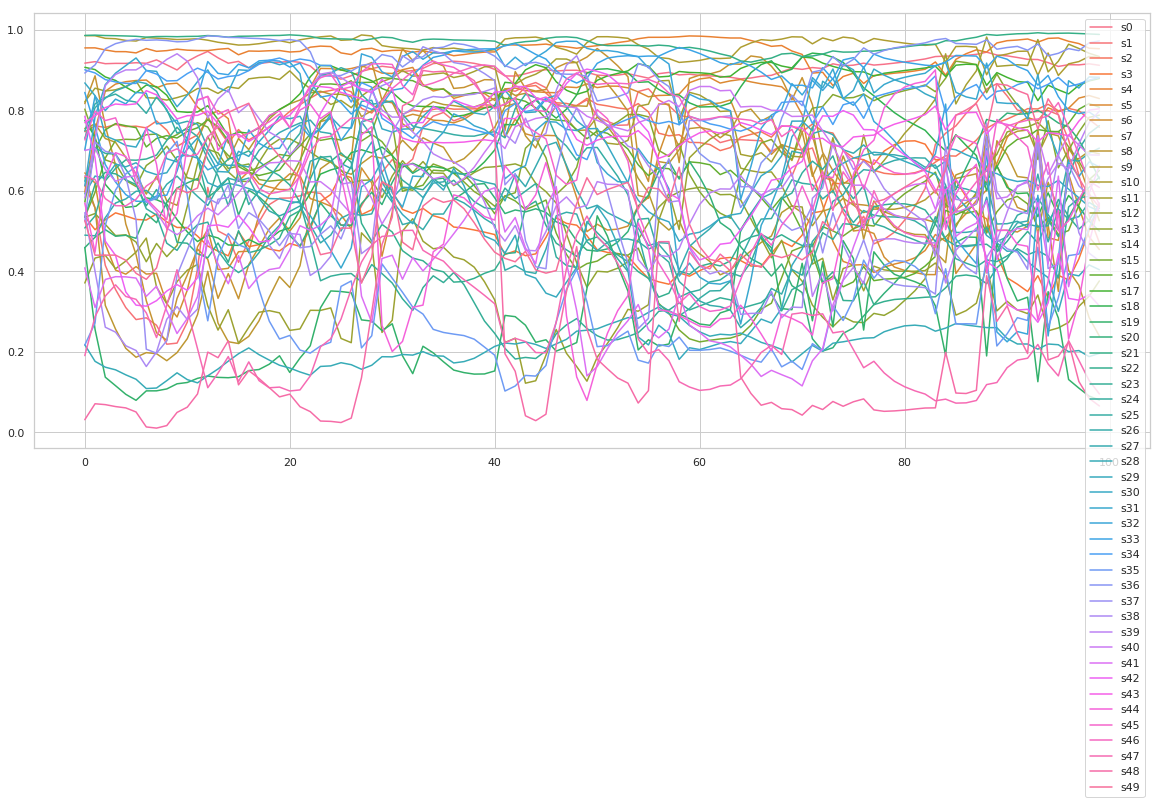

In [13]:
# _d = all_out_prob[-1].squeeze(1).t().cpu()
h2w = 3
h = 8
fig, ax = plt.subplots(figsize=(20, 8))
data = pd.DataFrame({f's{i}': d for i, d in enumerate(_d[:50,:])})
# print(data)
sns.lineplot(data=data, dashes=False, ax=ax)

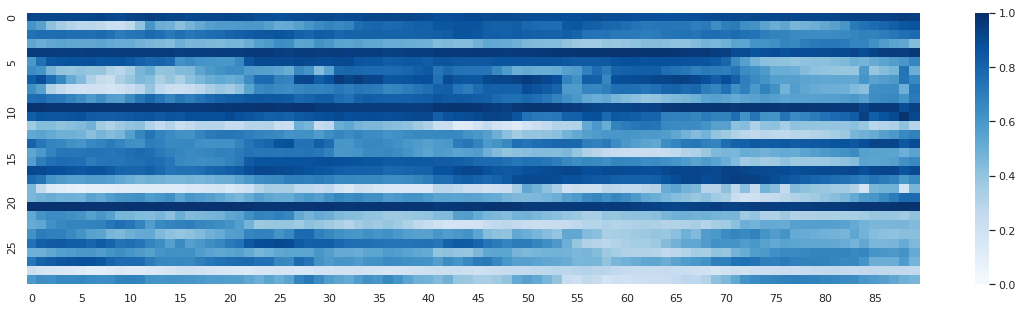

In [14]:
# _d = all_out_prob[-1].squeeze(1).t().cpu()
h2w = 3
h = 8
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(_d[0:30,0:90], vmin=0, vmax=1, ax=ax,
            cmap="Blues", xticklabels=5, yticklabels=5)